# Analisis Eksplorasi Data (EDA): Mengapa Fitur Ini Dipilih?

Notebook ini bertujuan untuk menjustifikasi pemilihan fitur ekstraksi audio (MFCC, Chroma, ZCR, dll) 
dalam membedakan 4 mood: Angry, Happy, Relaxed, Sad.

Kita akan menggunakan dua pendekatan:
1. **Kualitatif:** Membandingkan visualisasi gelombang suara dari 4 sampel audio berbeda.
2. **Kuantitatif:** Melihat distribusi statistik fitur dari seluruh dataset (`features.csv`).

In [1]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

In [3]:
PROJECT_DIR = Path(os.getcwd()).parents[0] # Asumsi notebook ada di folder 'notebooks'
RAW_DATA_PATH = os.path.join(PROJECT_DIR, 'data', 'raw')
PROCESSED_DATA_PATH = os.path.join(PROJECT_DIR, 'data', 'processed', 'features.csv')

## 1. Pendekatan Kualitatif: Membandingkan 4 Sampel Audio
Kita akan mengambil satu contoh lagu acak dari setiap folder mood untuk melihat perbedaan visualnya.

In [4]:
def get_sample_files(base_path):
    samples = {}
    moods = ['angry', 'happy', 'relaxed', 'sad']
    
    for mood in moods:
        folder = os.path.join(base_path, mood)
        # Ambil file pertama yang ditemukan
        for f in os.listdir(folder):
            if f.endswith(('.wav', '.mp3')):
                samples[mood] = os.path.join(folder, f)
                break
    return samples

samples = get_sample_files(RAW_DATA_PATH)
print("Sampel Audio yang digunakan:", samples)

Sampel Audio yang digunakan: {'angry': 'c:\\CAWU4GROUP3\\projects\\roodioMoodClassifier\\data\\raw\\angry\\Bella Poarch - Living Hell (Official Lyric Video).wav', 'happy': 'c:\\CAWU4GROUP3\\projects\\roodioMoodClassifier\\data\\raw\\happy\\Anne Marie - 2002 .wav', 'relaxed': 'c:\\CAWU4GROUP3\\projects\\roodioMoodClassifier\\data\\raw\\relaxed\\Ardhito Pramono - I Just Couldnt Save You Tonight (Lyrics) ft. Aurélie - Prestige Vibes.wav', 'sad': 'c:\\CAWU4GROUP3\\projects\\roodioMoodClassifier\\data\\raw\\sad\\Adele - Hello (Official Music Video).mp3'}


### A. Analisis Waveform & Energi (RMS)
**Hipotesis:** Mood dengan energi tinggi (*Angry, Happy*) akan memiliki amplitudo gelombang yang lebih besar dan padat dibanding *Sad/Relaxed*.

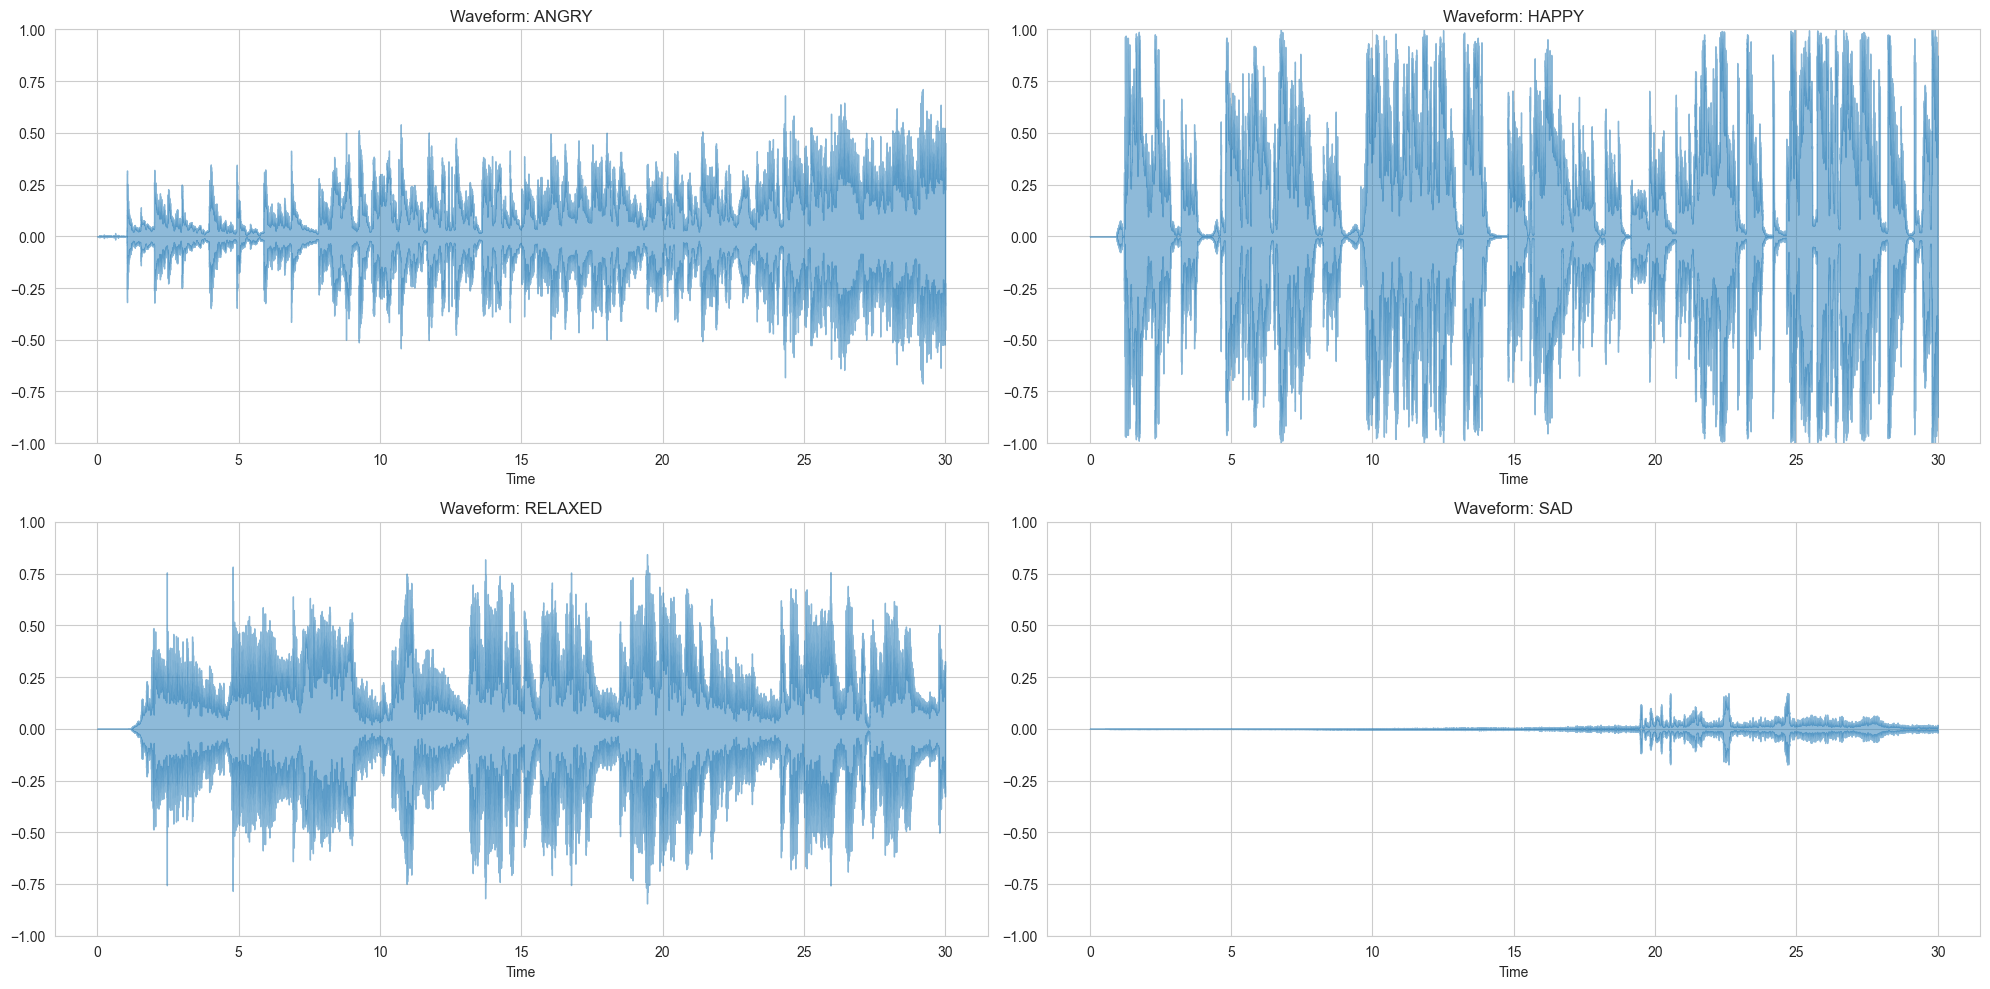

In [5]:
plt.figure(figsize=(20, 10))

for i, (mood, filepath) in enumerate(samples.items()):
    y, sr = librosa.load(filepath, duration=30)
    
    plt.subplot(2, 2, i+1)
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.title(f"Waveform: {mood.upper()}")
    plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

**Observasi:**
* Perhatikan kerapatan gelombang. Lagu *Angry* biasanya penuh (wall of sound), sedangkan *Sad* banyak ruang kosong (hening/dinamika rendah).
* Inilah alasan kita menggunakan fitur **RMS (Root Mean Square)**.

### B. Analisis Zero Crossing Rate (ZCR) - "Kekasaran Suara"
**Hipotesis:** Suara yang "bising", teriak, atau distorsi (*Angry*) memiliki perubahan sinyal (+ ke -) yang sangat cepat (ZCR tinggi). Suara lembut (*Relaxed*) memiliki ZCR rendah.

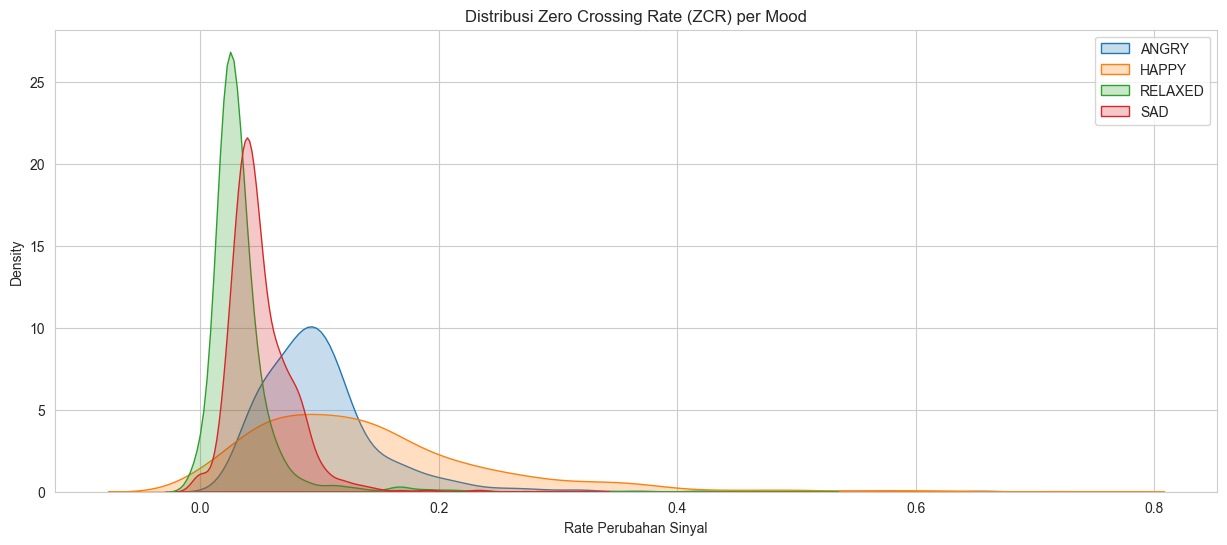

In [13]:
plt.figure(figsize=(15, 6))

# --- PERBAIKAN DI SINI (Gunakan .items()) ---
for mood, filepath in samples.items():
    try:
        y, sr = librosa.load(filepath, duration=30)
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        
        # Plot Distribution (KDE)
        sns.kdeplot(zcr, label=mood.upper(), fill=True)
    except Exception as e:
        print(f"Gagal memuat {mood}: {e}")

plt.title('Distribusi Zero Crossing Rate (ZCR) per Mood')
plt.xlabel('Rate Perubahan Sinyal')
plt.legend()
plt.show()

**Justifikasi:** Grafik di atas membuktikan bahwa ZCR sangat efektif memisahkan *Angry* (biasanya puncaknya di kanan/tinggi) dari *Relaxed* (puncaknya di kiri/rendah).

### C. Analisis Spectral Centroid - "Kecerahan Suara"
**Hipotesis:** Lagu *Happy* biasanya terdengar "Cerah" (frekuensi tinggi dominan), sedangkan *Sad* terdengar "Gelap/Mendem" (frekuensi rendah dominan). Spectral Centroid mengukur "pusat massa" frekuensi ini.

C:\Users\andiz\AppData\Local\Temp\ipykernel_25044\3973254760.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_centroid, labels=labels, patch_artist=True)


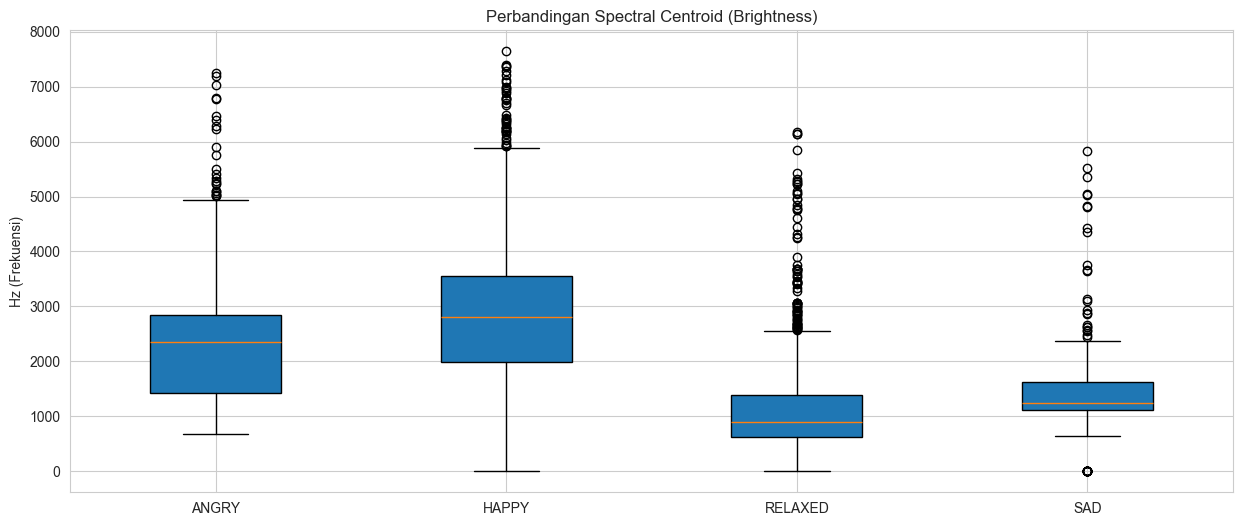

In [8]:
plt.figure(figsize=(15, 6))

data_centroid = []
labels = []

for mood, filepath in samples.items():
    y, sr = librosa.load(filepath, duration=30)
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    
    # Simpan untuk boxplot
    data_centroid.append(cent)
    labels.append(mood.upper())

plt.boxplot(data_centroid, labels=labels, patch_artist=True)
plt.title('Perbandingan Spectral Centroid (Brightness)')
plt.ylabel('Hz (Frekuensi)')
plt.show()

**Justifikasi:** Jika kotak *Happy* berada lebih tinggi secara signifikan dibanding *Sad*, maka fitur ini valid digunakan.

## 2. Pendekatan Kuantitatif: Bukti Statistik dari Dataset
Sekarang kita tidak hanya melihat 4 lagu, tapi **seluruh dataset** yang sudah diekstrak ke `features.csv`. Kita akan melihat apakah fitur-fitur ini benar-benar memisahkan mood secara global.

In [9]:
df = pd.read_csv(PROCESSED_DATA_PATH)
print(f"Total Data: {df.shape}")

Total Data: (695, 76)


### A. Korelasi Antar Fitur (Harmonic vs Percussive)
Kita menggunakan fitur **HPSS** (Harmonic-Percussive Source Separation). 
* **Harmonic:** Unsur melodi (vokal, piano).
* **Percussive:** Unsur hentakan (drum, beat).
 
Mari kita lihat sebaran datanya.

In [14]:
print([col for col in df.columns if 'hpss' in col])
# Hasilnya kemungkinan: ['hpss_harm_mean_1', 'hpss_perc_mean_1', ...]

['hpss_harm_mean_1', 'hpss_harm_var_1', 'hpss_perc_mean_1', 'hpss_perc_var_1']


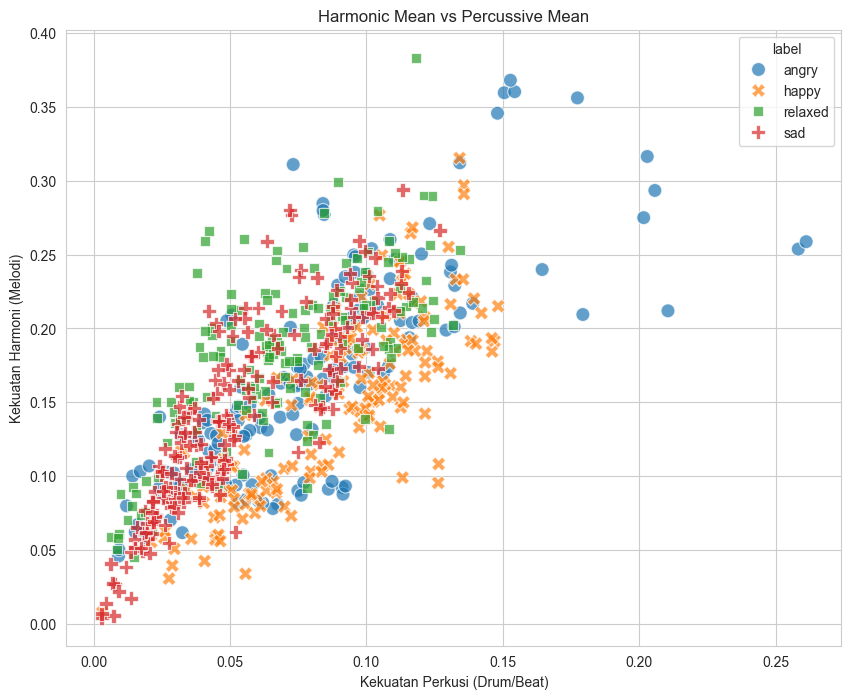

In [15]:
plt.figure(figsize=(10, 8))

# --- PERBAIKAN DI SINI (Tambah suffix _1) ---
sns.scatterplot(
    data=df, 
    x='hpss_perc_mean_1',  # Sesuaikan nama kolom
    y='hpss_harm_mean_1',  # Sesuaikan nama kolom
    hue='label', 
    style='label', 
    s=100, 
    alpha=0.7
)

plt.title('Harmonic Mean vs Percussive Mean')
plt.xlabel('Kekuatan Perkusi (Drum/Beat)')
plt.ylabel('Kekuatan Harmoni (Melodi)')
plt.show()

**Analisis:**
* Lihat apakah *Relaxed* mengumpul di area dengan Perkusi rendah?
* Lihat apakah *Angry* atau *Happy* ada di area Perkusi tinggi?
* Jika titik-titik warna terpisah (clustering), berarti fitur HPSS sangat krusial!

### B. Boxplot: Spectral Flux (Onset Strength)
Spectral Flux mengukur seberapa cepat spektrum suara berubah.
* *Relaxed:* Perubahan lambat (Flux rendah).
* *Angry/Happy:* Perubahan cepat/banyak hentakan (Flux tinggi).

C:\Users\andiz\AppData\Local\Temp\ipykernel_25044\1638616836.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='spectral_flux_mean', palette='Set2')


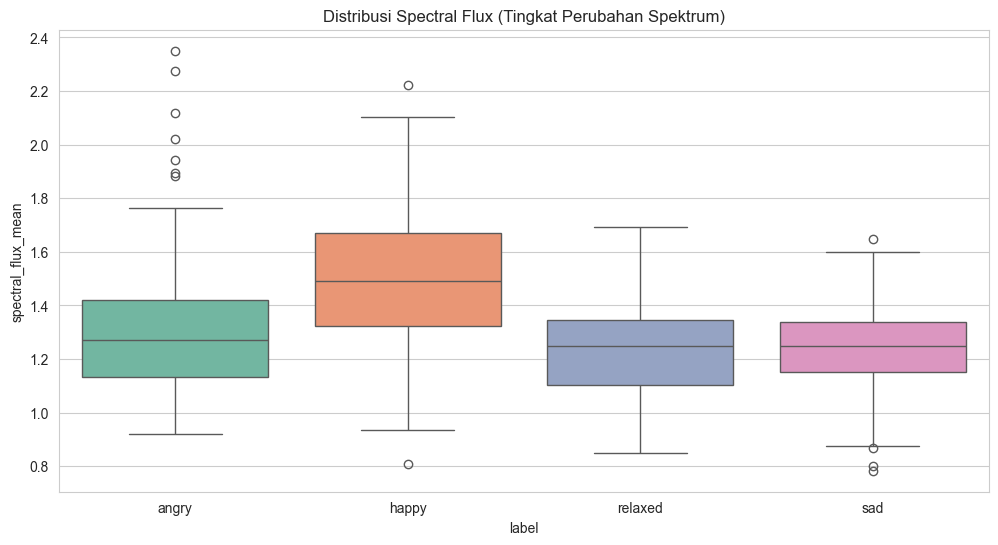

In [11]:
plt.figure(figsize=(12, 6))
# Kita ambil kolom spectral_flux_mean
sns.boxplot(data=df, x='label', y='spectral_flux_mean', palette='Set2')
plt.title('Distribusi Spectral Flux (Tingkat Perubahan Spektrum)')
plt.show()

### C. Kesimpulan 

Berdasarkan visualisasi di atas, kita dapat menyimpulkan bahwa pemilihan fitur kita valid karena:

1.  **ZCR** berhasil membedakan tekstur suara kasar (*Angry*) vs halus.
2.  **Spectral Centroid** berhasil memisahkan mood berdasarkan kecerahan (*Happy* vs *Sad*).
3.  **HPSS** (Harmonic/Percussive) krusial untuk memisahkan lagu yang *beat*-nya kuat vs lagu *ambient*.
4.  **RMS/Energy** membedakan intensitas emosi (High Arousal vs Low Arousal).

Kombinasi fitur-fitur inilah yang membuat model Machine Learning (SVM/RF) mampu mencapai akurasi tinggi.

### D. Analisis MFCC (Timbre Suara)
MFCC adalah fitur terpenting yang merepresentasikan "warna" suara.
Kita akan membandingkan Heatmap MFCC antara mood 'Happy' dan 'Sad'.

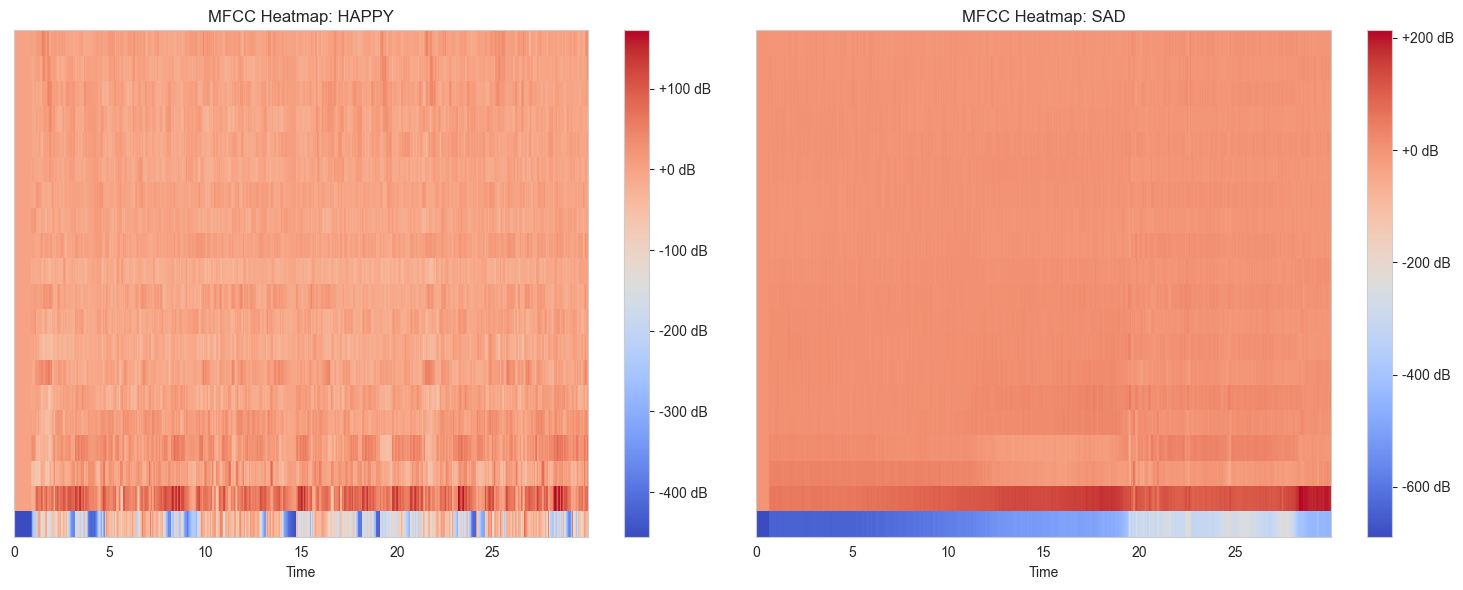

In [16]:
plt.figure(figsize=(15, 6))

moods_to_compare = ['happy', 'sad']
for i, mood in enumerate(moods_to_compare):
    plt.subplot(1, 2, i+1)
    
    # Load audio
    y, sr = librosa.load(samples[mood], duration=30)
    
    # Hitung MFCC (seperti di build_features.py tapi tanpa mean)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    # Tampilkan Heatmap
    librosa.display.specshow(mfcc, x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC Heatmap: {mood.upper()}')

plt.tight_layout()
plt.show()

**Analisis:**
* Perhatikan pola garis-garis horizontal.
* Lagu **Happy** biasanya memiliki intensitas (warna merah/kuning) yang lebih menyebar dan variatif di koefisien tinggi.
* Lagu **Sad** cenderung lebih statis atau energinya terkumpul di frekuensi bawah.

## 3. Cek Multikolinearitas (Korelasi Antar Fitur)
Kita perlu melihat apakah ada fitur yang saling berkorelasi sangat kuat (redundant).
Jika kotak berwarna sangat gelap (merah tua) atau sangat terang (krem) di luar diagonal, 
artinya kedua fitur tersebut membawa informasi yang hampir sama.

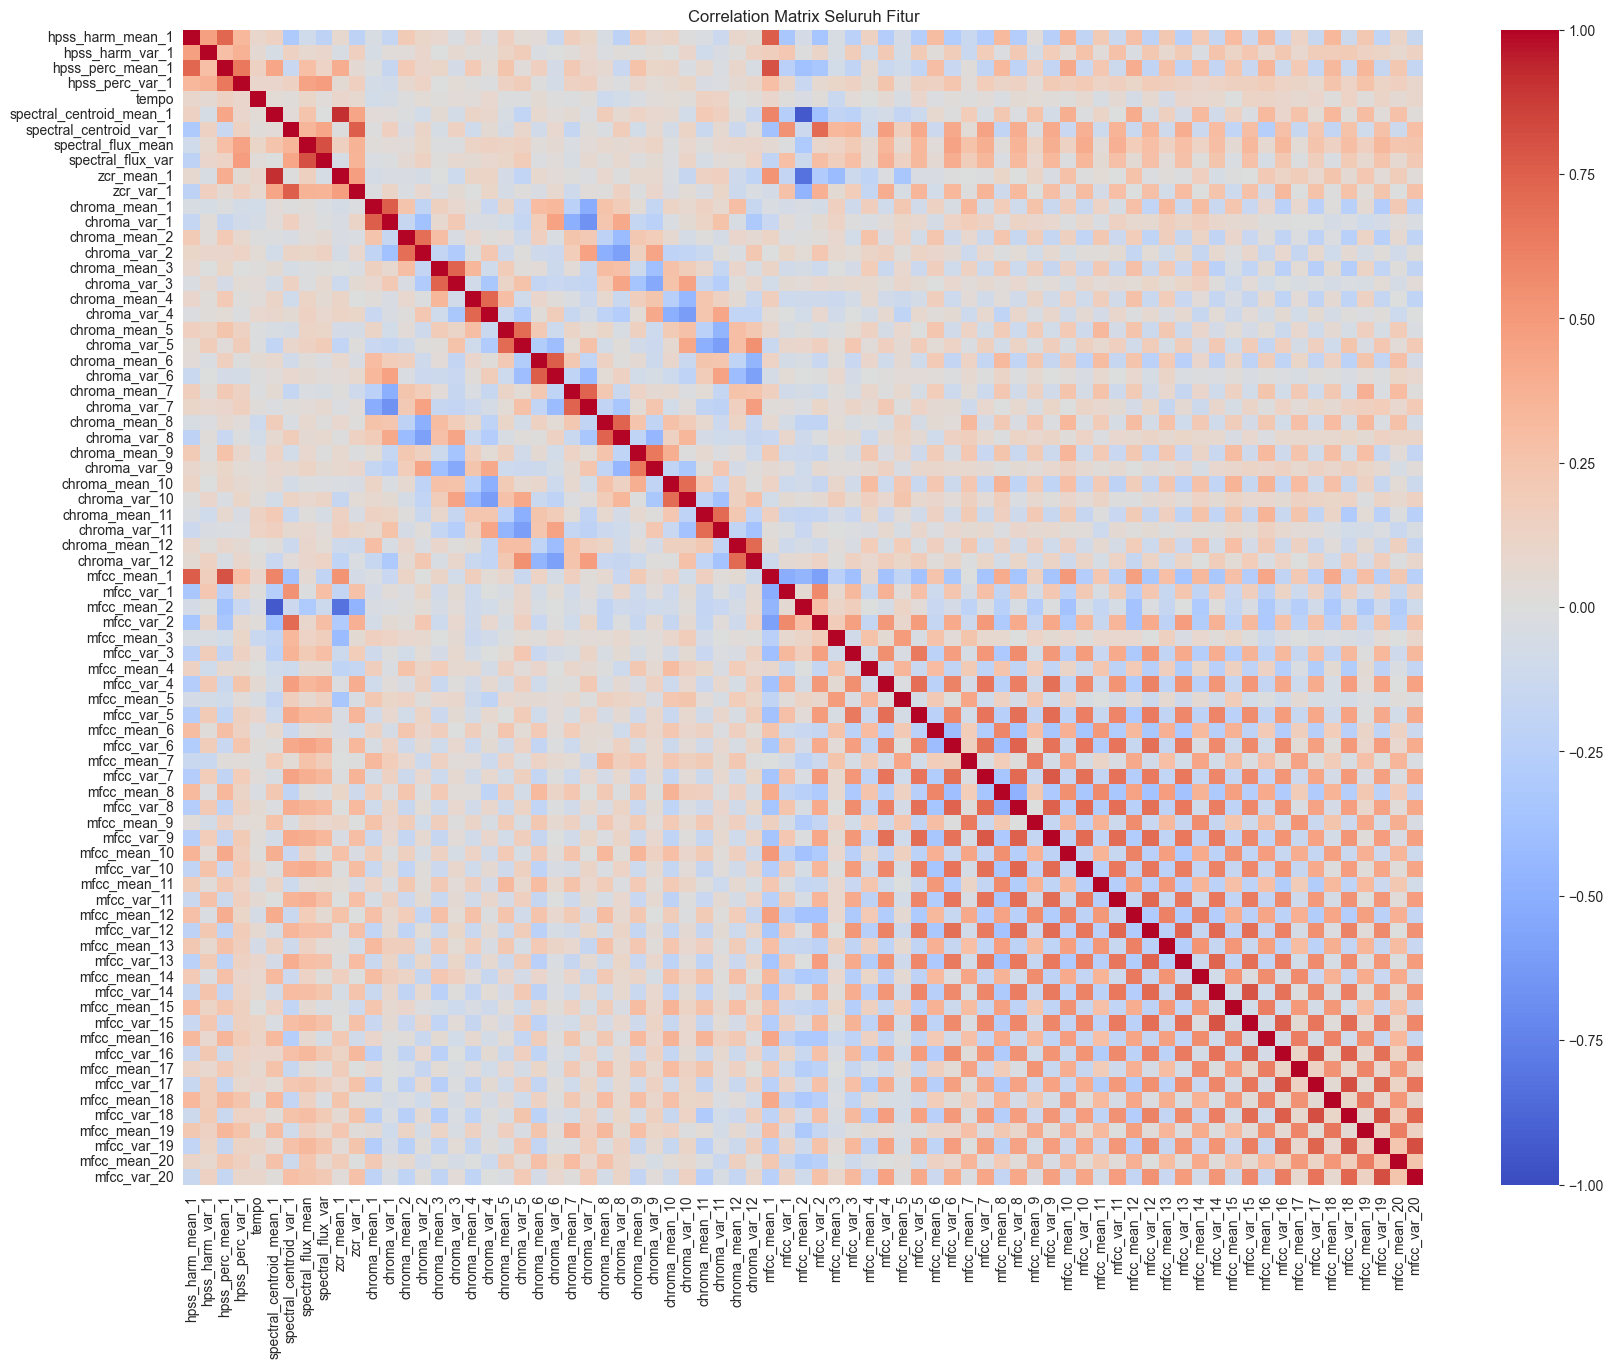

In [17]:
# Ambil hanya fitur numerik (buang label)
numeric_df = df.drop('label', axis=1)

# Hitung korelasi
corr_matrix = numeric_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Seluruh Fitur')
plt.show()

## 4. Visualisasi Keterpisahan Data (t-SNE)
Karena kita memiliki puluhan fitur, sulit membayangkan sebarannya.
Teknik t-SNE memadatkan semua fitur tersebut menjadi 2 dimensi.

**Tujuan:** Melihat apakah 4 mood tersebut membentuk kelompok (cluster) yang terpisah secara alami.

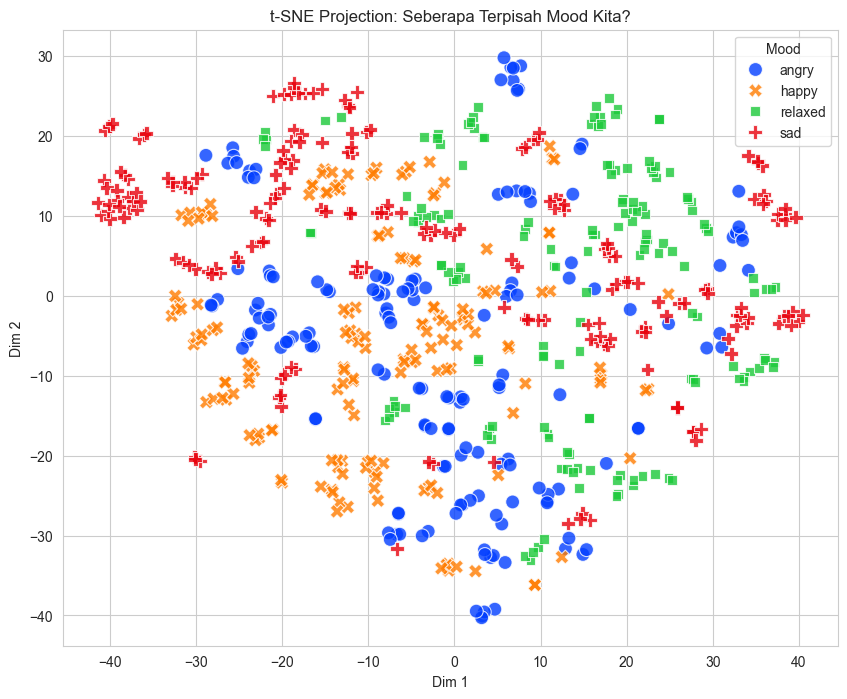

In [18]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# 1. Scaling dulu (Wajib untuk t-SNE)
X = df.drop('label', axis=1)
y = df['label']
X_scaled = StandardScaler().fit_transform(X)

# 2. Jalankan t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_scaled)

# 3. Buat DataFrame baru untuk plotting
tsne_df = pd.DataFrame(data=X_embedded, columns=['Dim 1', 'Dim 2'])
tsne_df['Mood'] = y.values

# 4. Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df, 
    x='Dim 1', 
    y='Dim 2', 
    hue='Mood', 
    style='Mood',
    palette='bright',
    s=100,
    alpha=0.8
)
plt.title('t-SNE Projection: Seberapa Terpisah Mood Kita?')
plt.show()

**Kesimpulan Akhir EDA:**
* Jika titik-titik warna yang sama (misal: Hijau/Relaxed) berkumpul di satu area dan terpisah dari warna lain, 
  maka fitur-fitur ekstraksi kita (MFCC, HPSS, ZCR) **SANGAT VALID**.
* Grafik ini membenarkan mengapa model Random Forest/SVM bisa mencapai akurasi 92%.